# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 6</span>


The **Ising model** is a concept to explain ferromagnetic properties of materials. In 1D, the Ising model consists of a chain of $N$ spins $s_i \in \pm 1$. If we assume that the interaction between two neighboring spins is described by a costant $J>0$, the Hamiltonian of the system in an external field $h$ is given by:

$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}),
$$

where we assume periodic boundary conditions, such that $s_{N+1}=s_1$. Here and in the following, we use the units $k_B = 1$ and $\mu_B = 1$. We describe the system using the **canonical ensemble**, such that the temperature $T$ is fixed. Given that the partition function of this system is analytically computable, we are able to calculate the theoretical values of the following thermodynamic variables:

1. Total energy: $U(N,T) = \langle H \rangle_{h=0}$
2. Heat capacity: $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. Magnetic susceptibility:$\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. Magnetization: $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

In this exercise sheet, we estimate these averages by simulating the spin system using the Metropolis algorithm and the Gibbs algorithm. One Monte Carlo step consists in trying to flip one time all the spins of the system. The Gibbs algorithm is a special form of the Metropolis algorithm, where the acceptance probability - by using conditional probabilities as the trial transition probability - is always one.

For the rest of this exercise sheet, whenever we use the term *simulation*, we intend the following procedure:

1. Choose temperature $T$ and external field $h$ of system
2. Equilibrate system starting from $T= \infty$ using $10^4$ Monte Carlo steps
3. Do $M_{max} = 20 \times 10^4$ Monte Carlo steps and compute thermodynamical variables of interest using blocking method with $N=20$ blocks 

### Equilibration 

The initialization of every simulation using $T=\infty$ means that we start from a completely unordered system, where every spin takes the values $\pm 1$ with equal probability. We have to ensure that the system reaches its **equilibrium** before starting our actual measurement of the thermodynamical variables. In the figure below, we illustrate the equilibration process consisting of $10000$ Monte Carlo steps for a system with $h = 0$ for the lowest ($T = 0.5$) and the highest temperature ($T = 2$) that we will use in the following. Note, that the variables illustrated in this plot - though not explicitly denoted - are no average values as in the following but rather values for the current (i.e. *one*) Monte Carlo step of the simulation (thus the clearly visible discretization around the theoretical value). Since - for both temperatures - the illustrated measures oscillate around their theoretical expectation, we conclude that $10000$ Monte Carlo steps are sufficient to equilibrate the system in the applied range of temperatures. 

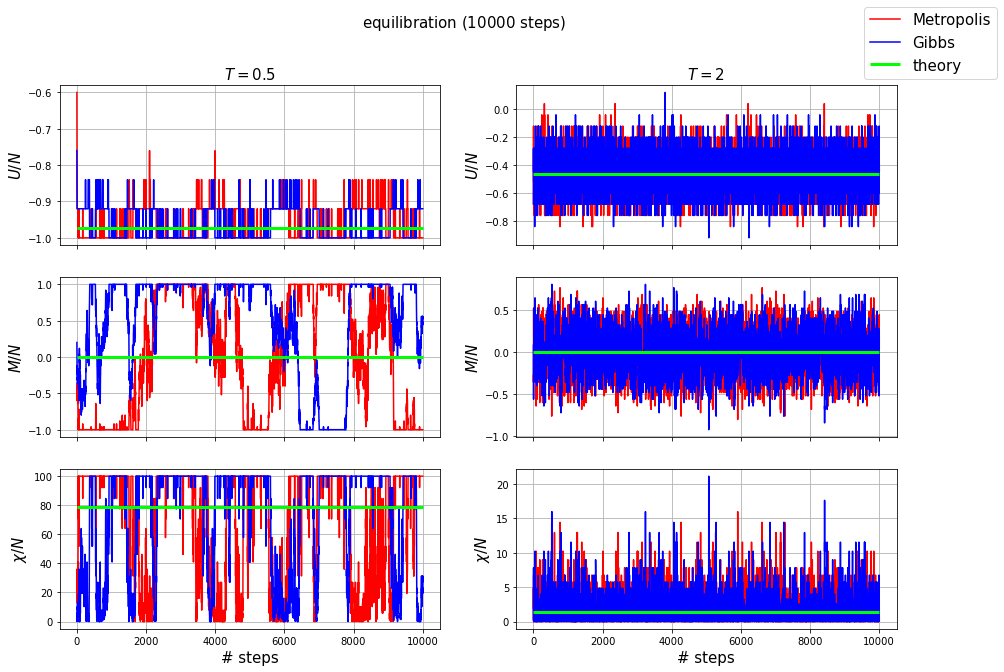

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

def calc_theo(T, J, Ns, h):
    '''
    Calculation of theoretical results given specific experimental parameters.
    Taken from exercise description.
    '''
    beta = 1/T
    th = np.tanh(J/T)
    thN = th**Ns
    ch = 1/th
   
    e = -J*( th + ch*thN )/( 1 + thN )
    heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
    b = 1/T
    l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    Z = l1**Ns + l2**Ns
    M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
            + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
    X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
    
    return e, heat, M, X

def equilibration_plot(ax, M, y_metro, y_gibbs, y_theo, ylabel, 
                       xlabel=None, title=None, label_metro=None, label_gibbs=None, label_theo=None):
    '''
    Plot equilibratioin of a certain measure for Metropolis simulation and Gibbs simulation and compare with theory.
    '''
    ax.plot(M, y_metro, color='r', label=label_metro)
    ax.plot(M, y_gibbs, color='b', label=label_gibbs)
    ax.hlines(y_theo, min(M), max(M), color='lime', zorder=10, linewidth=3, label=label_theo)
    ax.set_xlabel(xlabel, size=15)
    ax.set_ylabel(ylabel, size=15)
    ax.set_title(title, size=15)
    ax.grid()
    
# parameters
J = 1.0
Ns = 50

e_05, heat_05, M_05, X_05 = calc_theo(T=0.5, J=J, Ns=Ns, h=0)
e_2, heat_2, M_2, X_2 = calc_theo(T=2, J=J, Ns=Ns, h=0)

# load data rows from equilibration example
M, u_metro_05, chi_metro_05, m_metro_05 = np.loadtxt("data/metro_equi_05.txt", delimiter=',', skiprows=1, unpack=True)
M, u_gibbs_05, chi_gibbs_05, m_gibbs_05 = np.loadtxt("data/gibbs_equi_05.txt", delimiter=',', skiprows=1, unpack=True)
M, u_metro_2, chi_metro_2, m_metro_2 = np.loadtxt("data/metro_equi_2.txt", delimiter=',', skiprows=1, unpack=True)
M, u_gibbs_2, chi_gibbs_2, m_gibbs_2 = np.loadtxt("data/gibbs_equi_2.txt", delimiter=',', skiprows=1, unpack=True)

fig, ax = plt.subplots(3, 2, figsize=(15,10), sharex=True)
fig.suptitle("equilibration ($10000$ steps)", size=15)

equilibration_plot(ax[0, 0], M, u_metro_05, u_gibbs_05, e_05, 
                   "$U/N$", title="$T = 0.5$", label_metro="Metropolis", label_gibbs="Gibbs", label_theo="theory")
equilibration_plot(ax[0, 1], M, u_metro_2, u_gibbs_2, e_2, 
                   "$U/N$", title="$T = 2$")
equilibration_plot(ax[1, 0], M, m_metro_05, m_gibbs_05, M_05, 
                   "$M/N$")
equilibration_plot(ax[1, 1], M, m_metro_2, m_gibbs_2, M_2, 
                   "$M/N$")
equilibration_plot(ax[2, 0], M, chi_metro_05, chi_gibbs_05, X_05, 
                   "$\chi / N$", xlabel="# steps")
equilibration_plot(ax[2, 1], M, chi_metro_2, chi_gibbs_2, X_2, 
                   "$\chi / N$", xlabel="# steps")

fig.legend(fontsize=15)
plt.show()

### Simulation

The main part of this exercise sheet is the simulation (according to the above stated definition) of the described system for $J = 1$ for $30$ different temperatures in the range from $T_{min} = 0.5$ to $T_{max} = 2$. We measure $U/N$, $C/N$ and $\chi / N$ for a system  with no external field $h = 0$, while we use $h=0.02$ for the measurement of $M / N$ (otherwise the magnetization is $0$ for all temperatures). The results are displayed in the following four figures. We observe agreement between Metropolis and Gibbs sampling on the one hand and theoretical expectations on the other hand. The uncertainties on the thermodynamical variables are barely visible and increase for smaller temperatures.

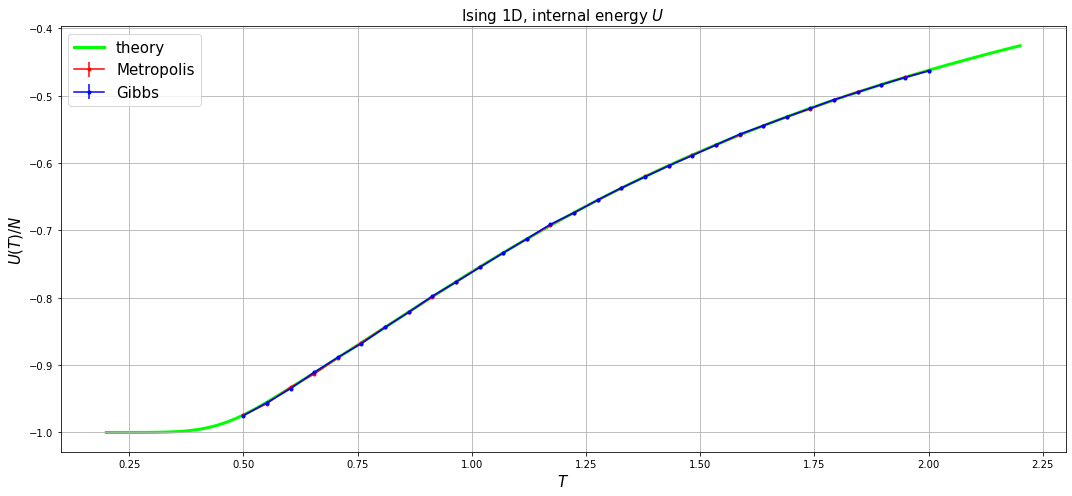

In [2]:
def compare_plot(title, x_label, y_label, T_sim, y_metro, err_metro, y_gibbs, err_gibbs, T_theo, y_theo):
    '''
    Plot comparison between theoretical results, Metropolis simulation and Gibbs simulation.
    '''
    plt.figure(figsize=(15, 7))
    
    plt.errorbar(T_sim, y_metro, err_metro, color='r', marker=".", label='Metropolis')
    plt.errorbar(T_sim, y_gibbs, err_gibbs, color='b', marker=".", label='Gibbs')
    plt.plot(T_theo, y_theo, color='lime', linewidth=3, zorder=0, label='theory')
    
    plt.title(title, size=15)
    plt.xlabel(x_label, size=15)
    plt.ylabel(y_label, size=15)
    
    plt.tight_layout()
    plt.grid()
    plt.legend(fontsize=15)
    plt.show()

# define some variables for theoretical calculations
points = 100
T = np.linspace(0.2, 2.2, num=points)
e, heat, M0, X = calc_theo(T, J=J, Ns=Ns, h=0)
M = calc_theo(T, J=J, Ns=Ns, h=0.02)[2]

# load results from simulation
T_sim, u_metro, u_err_metro, c_metro, c_err_metro, chi_metro, chi_err_metro = np.loadtxt("data/metro_h=0.txt", delimiter=',', skiprows=1, unpack=True, usecols=(0,1,2,3,4,5,6))
m_metro, m_err_metro = np.loadtxt("data/metro_h=0.02.txt", delimiter=',', skiprows=1, unpack=True, usecols=(7,8))
T_sim, u_gibbs, u_err_gibbs, c_gibbs, c_err_gibbs, chi_gibbs, chi_err_gibbs = np.loadtxt("data/gibbs_h=0.txt", delimiter=',', skiprows=1, unpack=True, usecols=(0,1,2,3,4,5,6))
m_gibbs, m_err_gibbs = np.loadtxt("data/gibbs_h=0.02.txt", delimiter=',', skiprows=1, unpack=True, usecols=(7,8))

compare_plot('Ising 1D, internal energy $U$', r'$T$', r'$U(T)/N$', T_sim, u_metro, u_err_metro, u_gibbs, u_err_gibbs, T, e)

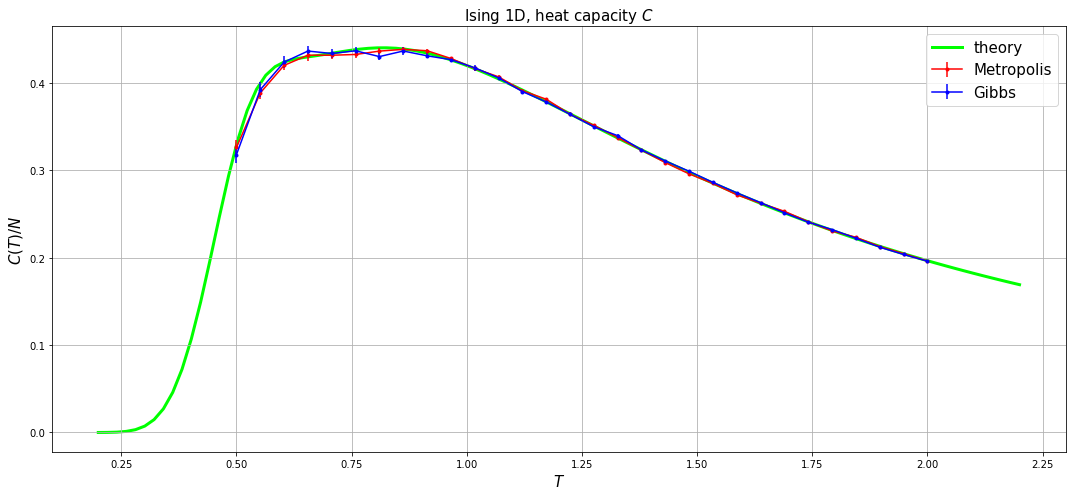

In [3]:
compare_plot('Ising 1D, heat capacity $C$', r'$T$', r'$C(T)/N$', T_sim, c_metro, c_err_metro, c_gibbs, c_err_gibbs, T, heat)

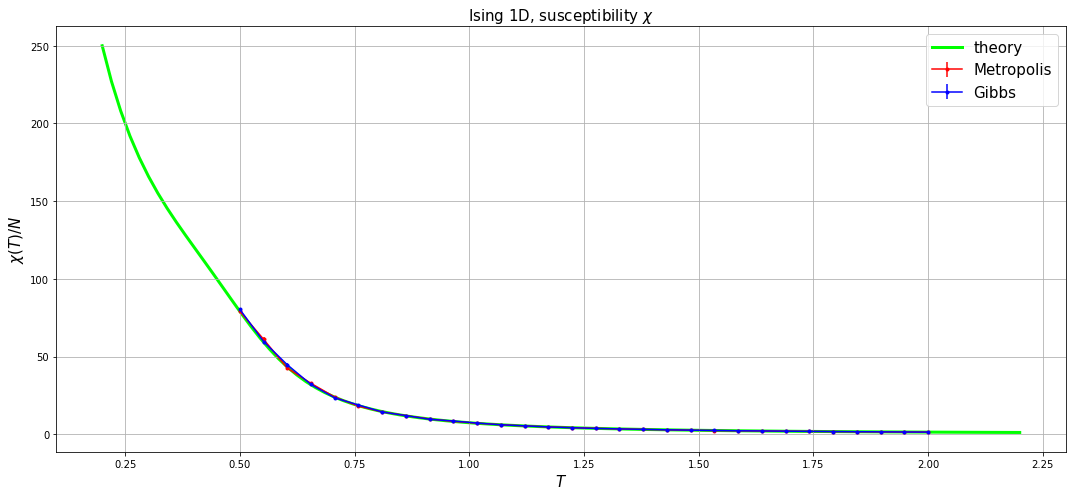

In [4]:
compare_plot('Ising 1D, susceptibility $\chi$', r'$T$', r'$\chi(T)/N$', T_sim, chi_metro, chi_err_metro, chi_gibbs, chi_err_gibbs, T, X)

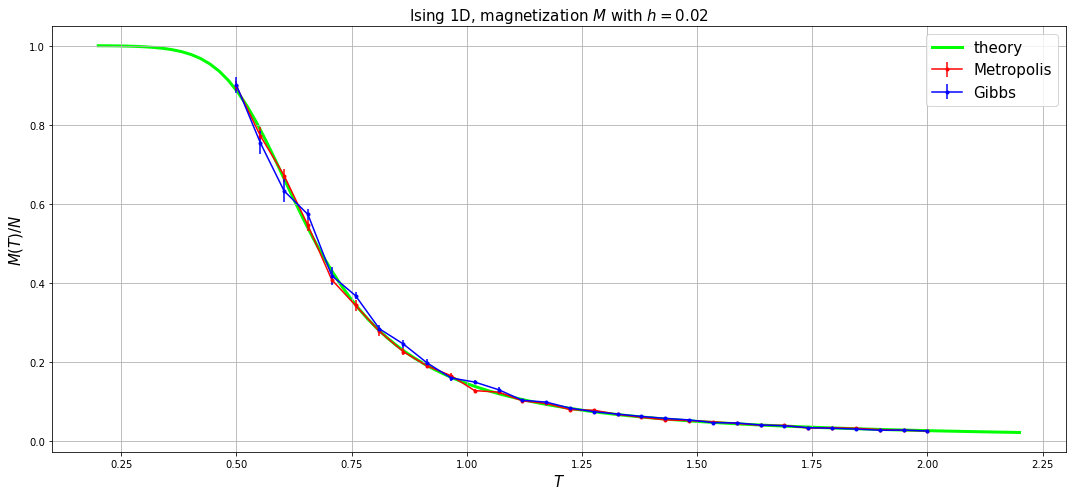

In [5]:
compare_plot('Ising 1D, magnetization $M$ with $h = 0.02$', r'$T$', r'$M(T)/N$', T_sim, m_metro, m_err_metro, m_gibbs, m_err_gibbs, T, M)